In [1]:
import os
import sys

In [2]:
import keras
# from keras.datasets import mnist
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
plt.style.use('seaborn')

In [4]:
sys.path.append(os.path.dirname(sys.path[0]))

import scripts.constants as con

In [5]:
CURRENT_DATA_NORMAL = '2021-09-24_prepared_1.3_normal'
PLOT_FILENAME_POSTFIX_NORMAL = 'prepared_1.3_normal'

PATH_TO_CURRENT_DATA_NORMAL = os.path.join(con.PATH_TO_DATA, CURRENT_DATA_NORMAL)
PATH_TO_CURRENT_DATA_NORMAL

'D:\\albert\\programming\\git_reps\\molecular_dynamics\\data\\2021-09-24_prepared_1.3_normal'

In [6]:
samples = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'samples.npy'))
test_sample = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'test_sample.npy'))
targets = np.load(os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'targets_pbc.npy'))

samples.shape, test_sample.shape, targets.shape

((2464, 612), (1, 612), (2464, 1372, 3))

In [7]:
def get_decoder(
        input_shape,
        output_shape,
        intermediate_dimension: int,
):
    inputs = keras.Input(shape=input_shape)
    outputs = layers.Dense(
        intermediate_dimension,
#         activation="relu",
    )(inputs)
#     outputs = layers.Dense(
#         intermediate_dimension,
#         activation='sigmoid',
#     )(outputs)
#     outputs = layers.Dense(
#         intermediate_dimension,
#         activation="relu",
#     )(outputs)
    outputs = layers.Reshape(output_shape)(outputs)
    return keras.Model(inputs, outputs, name="decoder")

In [8]:
DECODER = get_decoder(
    input_shape=samples.shape[1:],
    output_shape=targets.shape[1:],
    intermediate_dimension=np.array(targets.shape[1:]).prod(),
)
DECODER.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 612)]             0         
_________________________________________________________________
dense (Dense)                (None, 4116)              2523108   
_________________________________________________________________
reshape (Reshape)            (None, 1372, 3)           0         
Total params: 2,523,108
Trainable params: 2,523,108
Non-trainable params: 0
_________________________________________________________________


In [9]:
DECODER.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_squared_error',
)

In [10]:
DECODER.fit(
    samples, 
    targets, 
    epochs=50, 
    shuffle=True, 
    batch_size=200,
)

Epoch 1/50
13/13 [==============================] - 4s 182ms/step - loss: 7.1243
Epoch 2/50
13/13 [==============================] - 2s 183ms/step - loss: 5.5545
Epoch 3/50
13/13 [==============================] - 2s 175ms/step - loss: 5.2557
Epoch 4/50
13/13 [==============================] - 2s 186ms/step - loss: 5.1874
Epoch 5/50
13/13 [==============================] - 2s 188ms/step - loss: 5.1699
Epoch 6/50
13/13 [==============================] - 2s 183ms/step - loss: 5.1666
Epoch 7/50
13/13 [==============================] - 2s 172ms/step - loss: 5.1651
Epoch 8/50
13/13 [==============================] - 2s 164ms/step - loss: 5.1675
Epoch 9/50
13/13 [==============================] - 2s 158ms/step - loss: 5.1638
Epoch 10/50
13/13 [==============================] - 2s 176ms/step - loss: 5.1789
Epoch 11/50
13/13 [==============================] - 2s 186ms/step - loss: 5.1661
Epoch 12/50
13/13 [==============================] - 2s 174ms/step - loss: 5.1681
Epoch 13/50
13/13 [======

In [11]:
for i in range(10):
    print(
        tf.keras.metrics.mean_squared_error(DECODER.predict(np.array([samples[i]])), targets[i]).numpy().mean()
    )

7.909325490484906
7.852751318206943
7.884929584523756
7.932246546215034
7.953409071687499
7.95644770759235
7.93483881543412
7.959748183874971
7.929008796871508
7.862710523395536


In [12]:
predicted = DECODER.predict(test_sample)[0]
predicted

array([[ 4.756565  , -3.0414445 , -2.9809086 ],
       [ 0.3265209 ,  0.17024691,  3.8261206 ],
       [ 3.021497  ,  3.0632203 ,  0.5158962 ],
       ...,
       [-0.6410391 ,  4.949476  , -4.736176  ],
       [-1.6725765 ,  1.0683364 , -3.805836  ],
       [-1.975606  ,  4.3029933 , -4.814601  ]], dtype=float32)

In [13]:
PREDICTED = pd.DataFrame(predicted, columns=['x', 'y', 'z'])
PREDICTED[['v_x', 'v_y', 'v_z']] = 0.0
PREDICTED[['a_x', 'a_y', 'a_z']] = 0.0
PREDICTED[['L_x', 'L_y', 'L_z']] = 12.25
PREDICTED['particles_number'] = 1372
PREDICTED['time'] = 0.0

PREDICTED.to_csv(
    os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'predicted_configuration.csv'),
    sep=';', 
    index=False,
)

In [14]:
PREDICTED_RDF = pd.read_csv(
    os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'predicted_rdf_1.csv'),
    sep=';', 
)
PREDICTED_RDF

,radius,rdf
0,0.01,0.000000
1,0.02,0.000000
2,0.03,0.000000
3,0.04,0.000000
4,0.05,0.000000
...,...,...
607,6.08,1.015384
608,6.09,1.022109
609,6.10,0.983257
610,6.11,1.007102


In [15]:
LIMIT = 520

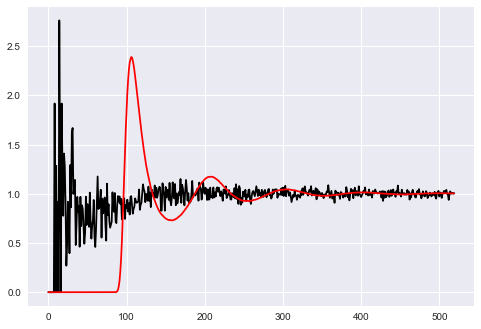

In [16]:
plt.plot(PREDICTED_RDF.head(LIMIT).rdf, color='black')
plt.plot(test_sample[0][:LIMIT], color='red')
plt.show()

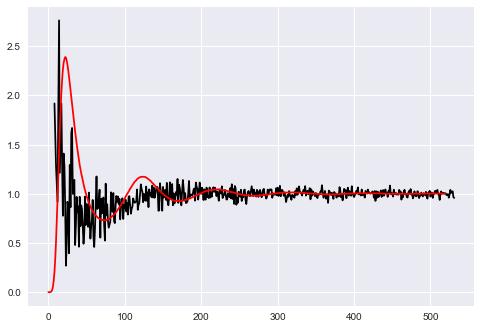

In [17]:
plt.plot(PREDICTED_RDF[PREDICTED_RDF.rdf > 0].head(LIMIT).rdf, color='black')
plt.plot(test_sample[0][test_sample[0] > 0][:LIMIT], color='red')
plt.show()

In [18]:
tf.keras.metrics.mean_squared_error(
    PREDICTED_RDF[PREDICTED_RDF.rdf > 0].head(LIMIT).rdf, 
    test_sample[0][test_sample[0] > 0][:LIMIT]
).numpy()

0.12238392800331695

In [19]:
samples[0].reshape(1, -1)
test_sample = samples[0].reshape(1, -1)

In [20]:
predicted = DECODER.predict(samples[0].reshape(1, -1))[0]
predicted

array([[ 4.767517  , -3.0300593 , -3.0077755 ],
       [ 0.31849828,  0.18318193,  3.827608  ],
       [ 3.0373151 ,  3.0337057 ,  0.5417754 ],
       ...,
       [-0.6338633 ,  4.9324055 , -4.7003183 ],
       [-1.6567606 ,  1.0840805 , -3.810625  ],
       [-1.981785  ,  4.2872415 , -4.783718  ]], dtype=float32)

In [21]:
PREDICTED = pd.DataFrame(predicted, columns=['x', 'y', 'z'])
PREDICTED[['v_x', 'v_y', 'v_z']] = 0.0
PREDICTED[['a_x', 'a_y', 'a_z']] = 0.0
PREDICTED[['L_x', 'L_y', 'L_z']] = 12.25
PREDICTED['particles_number'] = 1372
PREDICTED['time'] = 0.0

PREDICTED.to_csv(
    os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'predicted_configuration.csv'),
    sep=';', 
    index=False,
)

In [22]:
PREDICTED_RDF = pd.read_csv(
    os.path.join(PATH_TO_CURRENT_DATA_NORMAL, 'predicted_rdf_1.csv'),
    sep=';', 
)
PREDICTED_RDF

,radius,rdf
0,0.01,0.000000
1,0.02,0.000000
2,0.03,0.000000
3,0.04,0.000000
4,0.05,0.000000
...,...,...
607,6.08,1.015384
608,6.09,1.022109
609,6.10,0.983257
610,6.11,1.007102


In [23]:
LIMIT = 520

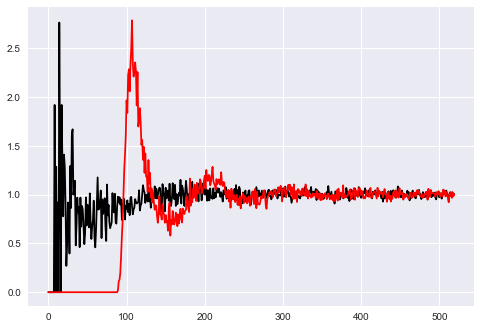

In [24]:
plt.plot(PREDICTED_RDF.head(LIMIT).rdf, color='black')
plt.plot(test_sample[0][:LIMIT], color='red')
plt.show()

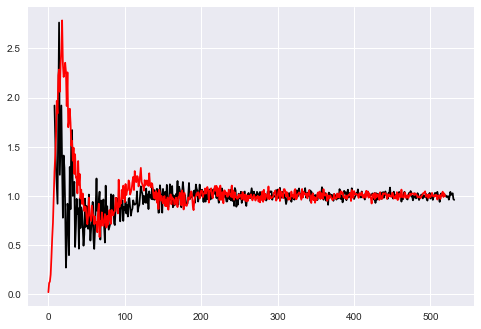

In [25]:
plt.plot(PREDICTED_RDF[PREDICTED_RDF.rdf > 0].head(LIMIT).rdf, color='black')
plt.plot(test_sample[0][test_sample[0] > 0][:LIMIT], color='red')
plt.show()

In [26]:
tf.keras.metrics.mean_squared_error(
    PREDICTED_RDF[PREDICTED_RDF.rdf > 0].head(LIMIT).rdf, 
    test_sample[0][test_sample[0] > 0][:LIMIT]
).numpy()

0.10807381430420007